In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import scipy
from scipy import stats as stats
from copy import copy as copy

from openpyxl import load_workbook
from openpyxl.worksheet.table import Table
# import seaborn as sns


In [2]:
writeOutput = False

In [3]:
os.getcwd()

'/Users/upton6/Library/CloudStorage/OneDrive-QueenslandUniversityofTechnology/Documents/notebooks/Nanostring/Adams_Bray/DSP_EDA_Protein'

In [4]:
# read in paths from config file
configDict = {
    'rootDir': '',
    'initialDataPath' : '',
    'QCDataPath' : '',
    'labWorksheet01Path':'',
    'sampleInfoFile' : '',
    'projectName':'',
}

with open('./config.txt','r') as f:
    lines = f.readlines()
    for line in lines:
        if not line.startswith('#'):
            line = line.strip()
            fields = line.split(':')

            if fields[0].strip()=='initialDataPath':
                configDict[fields[0].strip()] = fields[1].strip().strip('\'')
            else:
                configDict[fields[0].strip()] = fields[1].strip().strip('\'')
## ToDo: Add checks to ensure that minimal fields have been populated. Raise errors or warnings

In [5]:
configDict

{'rootDir': '/Users/upton6/Documents/Nanostring/projects/Adams/',
 'initialDataPath': 'Initial Dataset.xlsx',
 'QCDataPath': 'Initial QC_2024_04_26.xlsx',
 'labWorksheet01Path': 'Lab_Worksheet_P1001660017100A.txt',
 'sampleInfoFile': 'sampleInfo_with_Wells.csv',
 'projectName': 'Adams_Bray'}

# Define functions

# Run Analysis

In [6]:
# ToDo:
# add sample info file details into config file in previous notebook
# sampleInfo_with_Wells.csv

In [7]:
# ToDo: Should initial filtering be done using none-mean-HKGeoMean normalised data. Using a type of background subtraction for filtering would bias towards removing noisy or low expressing samples. Removing these may give more accurate estimates of real probe values.

In [8]:
sampleInfo = pd.read_csv(os.path.join(configDict['rootDir'], configDict['sampleInfoFile']), index_col=0)

In [9]:
sampleInfo

,TMA_001_TNBC_240327a_001_Segment 1,TMA_001_TNBC_240327a_002_Segment 1,TMA_001_TNBC_240327a_003_Segment 1,TMA_001_TNBC_240327a_004_Segment 1,TMA_001_TNBC_240327a_005_Segment 1,TMA_001_TNBC_240327a_006_Segment 1,TMA_001_TNBC_240327a_007_Segment 1,TMA_001_TNBC_240327a_008_Segment 1,TMA_001_TNBC_240327a_009_Segment 1,TMA_001_TNBC_240327a_010_Segment 1,...,TMA_002_TNBC_240327_029_Segment 1,TMA_002_TNBC_240327_030_Segment 1,TMA_002_TNBC_240327_031_Segment 1,TMA_002_TNBC_240327_032_Segment 1,TMA_002_TNBC_240327_033_Segment 1,TMA_002_TNBC_240327_034_Segment 1,TMA_002_TNBC_240327_035_Segment 1,TMA_002_TNBC_240327_036_Segment 1,TMA_002_TNBC_240327_037_Segment 1,TMA_002_TNBC_240327_038_Segment 1
Custom Segment Name,TMA_001_TNBC_240327a | 001 | Segment 1,TMA_001_TNBC_240327a | 002 | Segment 1,TMA_001_TNBC_240327a | 003 | Segment 1,TMA_001_TNBC_240327a | 004 | Segment 1,TMA_001_TNBC_240327a | 005 | Segment 1,TMA_001_TNBC_240327a | 006 | Segment 1,TMA_001_TNBC_240327a | 007 | Segment 1,TMA_001_TNBC_240327a | 008 | Segment 1,TMA_001_TNBC_240327a | 009 | Segment 1,TMA_001_TNBC_240327a | 010 | Segment 1,...,TMA_002_TNBC_240327 | 029 | Segment 1,TMA_002_TNBC_240327 | 030 | Segment 1,TMA_002_TNBC_240327 | 031 | Segment 1,TMA_002_TNBC_240327 | 032 | Segment 1,TMA_002_TNBC_240327 | 033 | Segment 1,TMA_002_TNBC_240327 | 034 | Segment 1,TMA_002_TNBC_240327 | 035 | Segment 1,TMA_002_TNBC_240327 | 036 | Segment 1,TMA_002_TNBC_240327 | 037 | Segment 1,TMA_002_TNBC_240327 | 038 | Segment 1
ROI,1c2ab061-972b-4227-95e9-5258d51c8e27,b465b231-4735-4036-96b5-51b75b387433,208ede3e-c633-4f23-aa77-98412fc80c33,795bf454-325f-40a8-9744-3e088eb71cec,f95ab5f3-aa46-458d-b657-fcf4da694848,c2b9cab2-4124-4e13-9f5e-c634210d5af5,d249163c-c8a6-46ba-bbb3-a39f0f0a93d1,77faae21-78b9-437c-8ce0-a93b8e340569,a33ff91d-2a1c-47c5-be42-c03423987723,853d0bb8-b16b-4567-8a75-c1127af5e57f,...,852af546-4f91-4845-a36c-c49449eb1ee6,3d1960fd-9a3d-4635-89cb-d6093cbf81de,2577a945-3961-427a-912d-10dc93135cac,18c6bdc1-6bc1-4053-9afb-3a10cb0dc60d,98dfd2d2-fc16-417d-901c-231d0e053254,47883f38-25d7-424f-8dc4-026f8ee02967,575d0d4c-a539-4ea9-a9c5-fa3df2aadfd8,17d4cd04-13ca-4edc-bdf5-85be0cbd264b,da0594eb-7ac1-454e-8fe1-18754987426f,7e12d16f-bb81-4172-aa51-7da692483286
ROI (Label),001,002,003,004,005,006,007,008,009,010,...,029,030,031,032,033,034,035,036,037,038
Segment,7936d809-ce05-4697-b1fd-f78adfeed555,0a7b8f61-078d-4877-9053-b53e5fd4614d,9e6564c7-7f87-44e1-8de7-7f264d9652e7,0c24d8bc-0bda-426f-b551-fb56e83f7c48,bb3efaed-92cb-44c8-bded-6c412faa3f28,aff1a8fa-0906-450a-8e6e-190b5c311c15,8897d9f1-29c0-4c8e-a85a-4d2317b9ee98,cfa789e4-02ec-4a0a-b079-809521dacd98,2e38b3b5-6108-4c67-bae4-1407b409ed5d,b428322e-fb26-4468-bc22-6880eb3d74d6,...,47ef0fac-b270-450b-a899-19afaf3a8c49,5fd178e2-2b3d-40b0-b9fb-b1158c7d3113,8ece77c9-a4cc-4926-9f90-f9d892cb6a51,528d80c9-6779-47c6-94ef-64c720aba698,1e4bf2f8-0088-4203-9827-f7d3fcb34146,5bbe2794-98f8-46df-b826-b7b77e7fc6a7,fa9c6ff6-c60a-4d6e-8065-9521674aeb0e,98b86df7-0282-422b-8758-24a7bdeec98d,990b2e46-dd95-435f-8a53-72cc2096df4d,54be0368-acf2-4d5c-809c-6a878f988fca
Segment (Name/ Label),Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,...,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1
ROI X Coordinate,15998.4228515625,17548.470703125,22190.41015625,21641.412109375,28156.294921875,29460.4453125,34450.37890625,35965.6796875,14040.1318359375,22770.828125,...,16045.6611328125,18286.287109375,15990.0439453125,9614.58203125,11774.5908203125,15884.0,17818.0,10855.0,18335.0,10963.0
ROI Y Coordinate,47604.875,42694.140625,49197.96875,39689.90625,46551.5703125,38989.8515625,47247.91015625,37720.6171875,33845.1171875,32324.01171875,...,42486.55859375,44687.47265625,53921.28125,46081.296875,46319.25390625,23071.0,22113.0,29783.0,38071.0,43305.0
Segment Tags,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,...,Segment 1,Seg

In [10]:
colTemp = sampleInfo.columns
colTemp = [x.replace(' ','.') for x in colTemp]
colTemp = [x.replace('-','.') for x in colTemp]
sampleInfo.columns = colTemp


In [11]:
factors = input('enter factors to be used for groups to check probe expression. separate multiple factors by a comma')

enter factors to be used for groups to check probe expression. separate multiple factors by a comma Row, Col


In [12]:
factors = factors.split(',')
factors = [f.strip() for f in factors]
factors

['Row', 'Col']

In [13]:
# generate a dictionary to hold factors for group analysis
factorDict = {}
factorDict2 = {}

for f in factors:
    entries = list(set(sampleInfo.loc[f].values))
    print(entries)
    factorDict[f] = entries
    factorDict2[f] = {}
    for e in entries:
        factorDict2[f][e] = sampleInfo.columns[sampleInfo.loc[f] == e]
    

['A', 'C', 'H', 'E', 'G', 'D', 'F', 'B']
['05', '01', '02', '06', '08', '11', '04', '03', '10', '09', '12', '07']


In [14]:
factorDict.keys()

dict_keys(['Row', 'Col'])

In [15]:
factorDict2

{'Row': {'A': Index(['TMA_001_TNBC_240327a_001_Segment.1',
         'TMA_001_TNBC_240327a_002_Segment.1',
         'TMA_001_TNBC_240327a_003_Segment.1',
         'TMA_001_TNBC_240327a_004_Segment.1',
         'TMA_001_TNBC_240327a_005_Segment.1',
         'TMA_001_TNBC_240327a_006_Segment.1',
         'TMA_001_TNBC_240327a_007_Segment.1',
         'TMA_001_TNBC_240327a_008_Segment.1',
         'TMA_001_TNBC_240327a_009_Segment.1',
         'TMA_001_TNBC_240327a_010_Segment.1',
         'TMA_001_TNBC_240327a_011_Segment.1',
         'TMA_001_TNBC_240327a_012_Segment.1'],
        dtype='object'),
  'C': Index(['TMA_001_TNBC_240327a_025_Segment.1',
         'TMA_001_TNBC_240327a_026_Segment.1',
         'TMA_001_TNBC_240327a_027_Segment.1',
         'TMA_001_TNBC_240327a_028_Segment.1',
         'TMA_001_TNBC_240327a_029_Segment.1',
         'TMA_001_TNBC_240327a_030_Segment.1',
         'TMA_001_TNBC_240327a_031_Segment.1',
         'TMA_001_TNBC_240327a_032_Segment.1',
         'TMA_001

# Visualise Nanostring Norm results and choose samples to be kept for final normalisation

In [16]:
configDict

{'rootDir': '/Users/upton6/Documents/Nanostring/projects/Adams/',
 'initialDataPath': 'Initial Dataset.xlsx',
 'QCDataPath': 'Initial QC_2024_04_26.xlsx',
 'labWorksheet01Path': 'Lab_Worksheet_P1001660017100A.txt',
 'sampleInfoFile': 'sampleInfo_with_Wells.csv',
 'projectName': 'Adams_Bray'}

In [17]:
normDir = os.path.join(configDict['rootDir'], 'Normalisation')

In [18]:
normDir

'/Users/upton6/Documents/Nanostring/projects/Adams/Normalisation'

In [19]:
QCDataFile = [f for f in os.listdir(normDir) if (f.startswith('QC') and f.endswith('RUV.csv'))][0]

In [20]:
QCDataFile

'QC_Adams_Bray_RUV.csv'

In [21]:
# tempDF

### Sort samples and probes 

In [22]:
# tempDF1 = pd.read_csv(os.path.join(normDir, 'NSNorm',files[0]), index_col=0)
# v = tempDF1.mean(axis=1).sort_values().index

# sampleOrder = sorted(tempDF1.columns)

In [23]:
QCDataDF = pd.read_csv(os.path.join(normDir, QCDataFile), index_col=0)
QCDataDF.columns = [x.replace(' ','.') for x in QCDataDF.columns]
QCDataDF.columns = [x.replace('-','.') for x in QCDataDF.columns]


probeOrder = QCDataDF.index[8:]
sampleOrder = QCDataDF.columns[1:]

# sampleOrder

In [24]:
files = os.listdir(os.path.join(normDir, 'NSNorm'))
files = sorted(files)
# # print(len(files))
# # print(files)

# fileIdx = 0
# tempFile = os.path.join(normDir, 'NSNorm',files[fileIdx])

# print(tempFile)
# tempDF = pd.read_csv(os.path.join(normDir, 'NSNorm',files[fileIdx]), index_col=0)


In [25]:
probeOrder

Index(['CD8', 'CD4', 'GZMB', 'Fibronectin', 'Beta-2-microglobulin', 'PD-1',
       'HLA-DR', 'CD3', 'CD56', 'CD11c', 'CTLA4', 'CD68', 'PanCk', 'SMA',
       'CD20', 'PD-L1', 'CD45', 'Ki-67', 'CD25', 'ICOS', 'CD80', 'CD27',
       'PD-L2', 'CD127', 'CD40', 'CD44', 'CD34', 'CD163', 'CD45RO', 'FOXP3',
       'CD14', 'FAP-alpha', 'CD66b', 'PTEN', 'EpCAM', 'Her2', 'S100B', 'Bcl-2',
       'NY-ESO-1', 'PR', 'MART1', 'ER-alpha', 'IDO1', 'Tim-3', '4-1BB',
       'STING', 'GITR', 'OX40L', 'VISTA', 'B7-H3', 'LAG3', 'ARG1', 'MET',
       'INPP4B', 'PLCG1', 'Phospho-GSK3A (S21)/Phospho-GSK3B (S9)',
       'Phospho-Tuberin (T1462)', 'Phospho-AKT1 (S473)', 'Pan-AKT',
       'Phospho-PRAS40 (T246)', 'Phospho-GSK3B (S9)', 'BCLXL', 'BIM', 'BCL6',
       'CD95/Fas', 'BAD', 'PARP', 'p53', 'Neurofibromin', 'GZMA',
       'Cleaved Caspase 9'],
      dtype='object', name='Name')

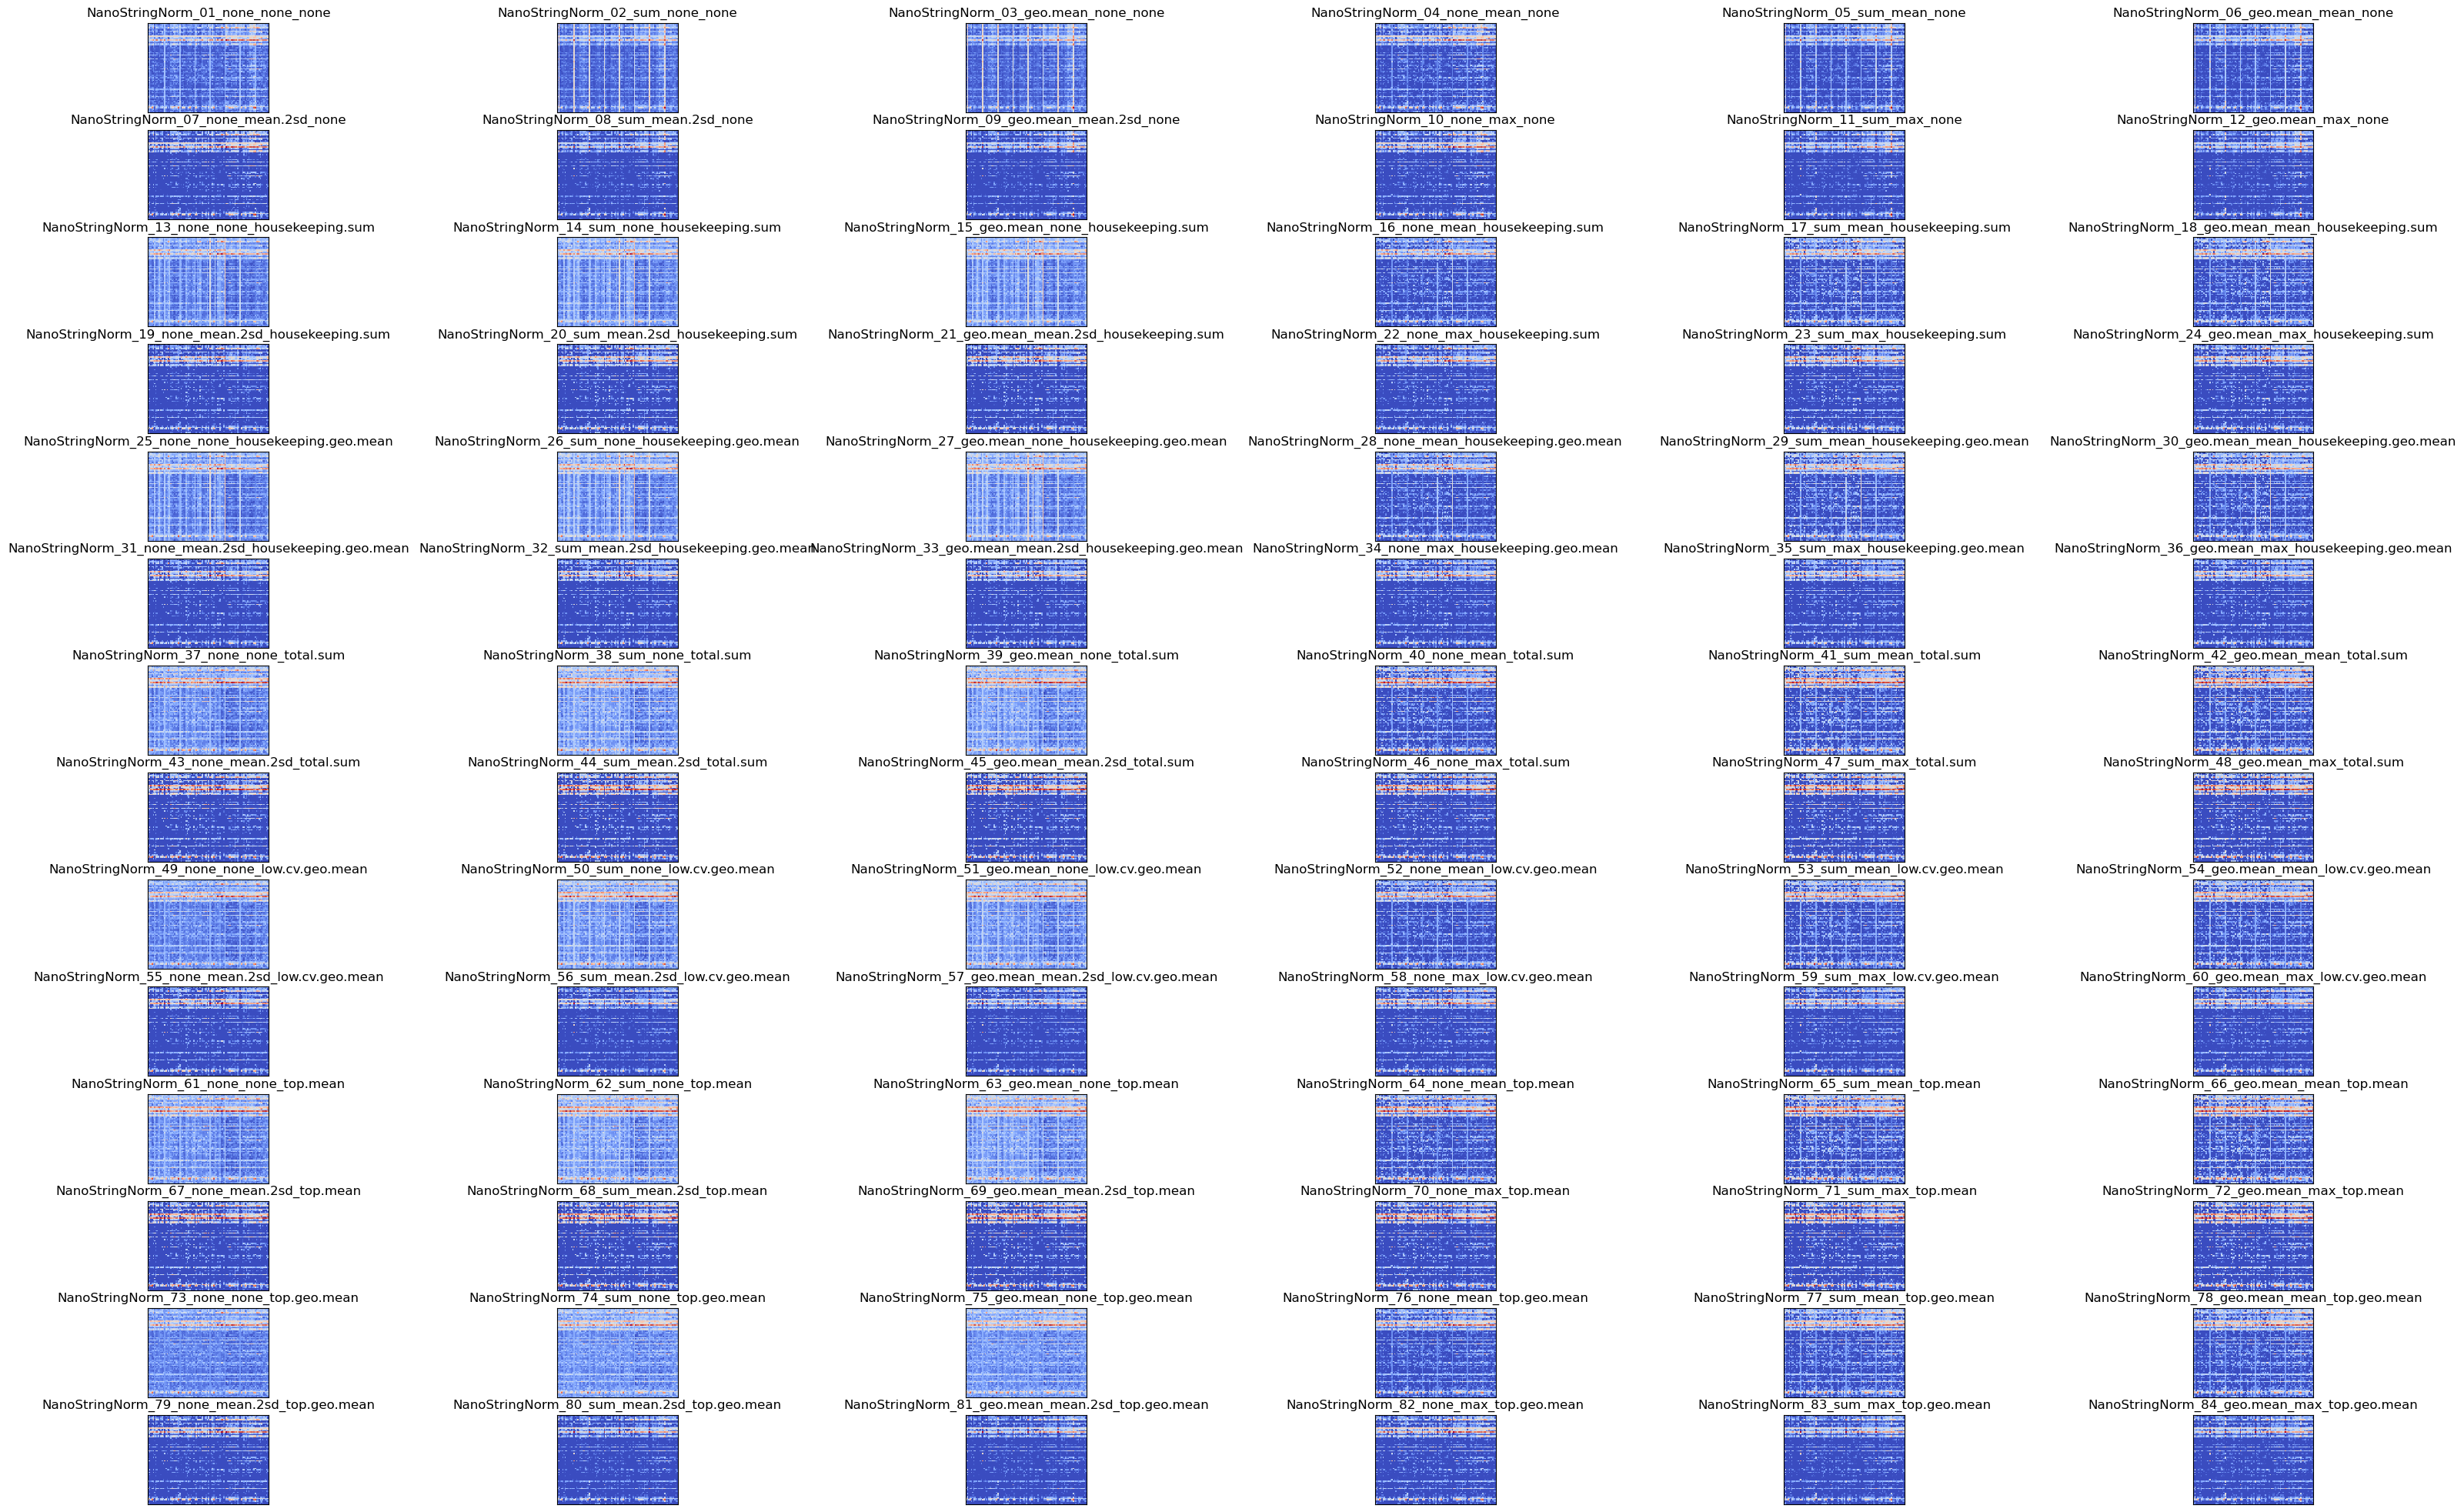

In [26]:
width = 6
height = 14


fig, axs = plt.subplots(height, width, figsize=[40,25])
# fig.suptitle('Nanostring Normalisation heatmaps')

for y in range(height):
    for x in range(width):
        fileIdx = x + y*width
        tempDF = pd.read_csv(os.path.join(normDir, 'NSNorm',files[fileIdx]), index_col=0)
#         axs[y][x].matshow(np.log2(tempDF + 1), aspect = 'auto', cmap='coolwarm')
        axs[y][x].matshow(np.log2(tempDF.loc[probeOrder,sampleOrder] + 1), cmap='coolwarm')
        axs[y][x].set_xticks([])
        axs[y][x].set_yticks([])
        axs[y][x].set_title(files[fileIdx][:-4])
    
# plt.tight_layout()
# fig.show()

# Threshold data

In [27]:
controlSet = set(['HYB-NEG', 'HYB-POS', 'Rb IgG', 'Ms IgG2a', 'Ms IgG1'])

### Threshold probes and drop low or null expressing probes

In [28]:
threshold = 1.5
expPropCutOff = 0.5
SamplePropCutOff = 0.5

dropList = []

for f in factorDict2.keys():
    print(f)
    for g in factorDict2[f].keys():
        print(g)
        # print(factorDict2[f][g])
        groupLen = len(factorDict2[f][g])
        # print(groupLen)
        passThreshold = (QCDataDF[factorDict2[f][g]]>threshold).sum(axis=1)
        # print(passThreshold)
        passThreshProp = (passThreshold/groupLen) < expPropCutOff
        # print(passThreshProp)
        failIdx = QCDataDF.index[passThreshProp]
        print(failIdx)
        print(len(failIdx))

        if (len(failIdx) > 0):
            dropList.extend(list(failIdx))
        
        # print(QCDataDF.index[((QCDataDF[factorDict2[f][g]]>2).sum(axis=1)/groupLen) < 0.5])

dropList = list(set(dropList) - controlSet)
print(dropList)

Row
A
Index(['HYB-NEG', 'Rb IgG', 'PD-L1', 'CD25', 'ICOS', 'CD80', 'CD27', 'PD-L2',
       'CD40', 'CD34', 'CD163', 'FOXP3', 'CD14', 'CD66b', 'Her2', 'Bcl-2',
       'PR', 'MART1', '4-1BB', 'GITR', 'VISTA', 'B7-H3', 'LAG3', 'PLCG1',
       'Phospho-Tuberin (T1462)', 'Phospho-GSK3B (S9)', 'BIM', 'CD95/Fas'],
      dtype='object', name='Name')
28
C
Index(['HYB-NEG', 'Rb IgG', 'PD-L1', 'CD25', 'ICOS', 'CD80', 'CD27', 'PD-L2',
       'CD34', 'CD163', 'FOXP3', 'CD66b', 'EpCAM', 'Her2', 'Bcl-2', 'MART1',
       'IDO1', 'OX40L', 'VISTA', 'B7-H3', 'LAG3', 'ARG1', 'PLCG1',
       'Phospho-Tuberin (T1462)', 'Phospho-PRAS40 (T246)',
       'Phospho-GSK3B (S9)', 'BCLXL', 'BIM', 'CD95/Fas', 'GZMA'],
      dtype='object', name='Name')
30
H
Index(['HYB-NEG', 'CD25', 'CD80', 'CD34', 'Her2', 'PR', 'LAG3',
       'Phospho-Tuberin (T1462)', 'Phospho-PRAS40 (T246)'],
      dtype='object', name='Name')
9
E
Index(['Rb IgG', 'Ms IgG2a', 'PD-L1', 'ICOS', 'CD80', 'CD27', 'PD-L2', 'CD40',
       'CD34', 'FOXP3'

In [29]:
QCDataDF = QCDataDF.drop(index=dropList)

### Threshold samples and drop low or null expressing samples

In [30]:
dropSamples = list(QCDataDF[QCDataDF.columns[1:]].T[(QCDataDF[QCDataDF.columns[1:]]>threshold).sum(axis=0)/len(QCDataDF.index) < SamplePropCutOff].index)
print('dropSamples : ')
print(dropSamples)
QCDataDF = QCDataDF.drop(index=dropSamples, axis=1)
# QCDataDF

dropSamples : 
[]


- export data after dropping probes and samples due to low expression
- re-run NSNorm
- Continue with viewing data and QC of normalised data



In [31]:
# ToDo: Ask for project name interactively
project = configDict['projectName']

qcDropCSV = 'QC_' + project + '_RUV_Dropped.csv'

writeOutput = True
if writeOutput:
    QCDataDF.to_csv(os.path.join(normDir, qcDropCSV))
writeOutput= False

In [32]:
cmd = 'Rscript NSNorm.R -d ' + normDir + ' -s NSNormDropped -f ' + qcDropCSV
print(cmd)
os.system(cmd)

Rscript NSNorm.R -d /Users/upton6/Documents/Nanostring/projects/Adams/Normalisation -s NSNormDropped -f QC_Adams_Bray_RUV_Dropped.csv


Loading required package: matrixStats
Loading required package: ruv
Loading required package: NanoStringNorm
Loading required package: gdata

Attaching package: ‘gdata’

The following object is masked from ‘package:stats’:

    nobs

The following object is masked from ‘package:utils’:

    object.size

The following object is masked from ‘package:base’:

    startsWith

Loading required package: vsn
Loading required package: Biobase
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following object is masked from ‘package:gdata’:

    combine

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[1] 34 98
[1] 84  3

##############################
### NanoStringNorm v1.2.1.1 ###
##############################

There are 96 samples and 26 Endogenous genes 


##############################
### NanoStringNorm v1.2.1.1 ###
##############################

There are 96 samples and 26 Endogenous genes 

CodeCount: The following samples have positive normalization factors outside the 
	 recommended range of (0.3 to 3).  Consider removing them.

                                   pos.norm.factor
TMA_001_TNBC_240327a_002_Segment.1            8.16
TMA_001_TNBC_240327a_014_Segment.1           10.90
TMA_001_TNBC_240327a_026_Segment.1            8.99
TMA_001_TNBC_240327a_038_Segment.1            9.05
TMA_001_TNBC_240327a_050_Segment.1            9.43
TMA_002_TNBC_240327_004_Segment.1

0

In [33]:
files = os.listdir(os.path.join(normDir, 'NSNormDropped'))
files = sorted(files)


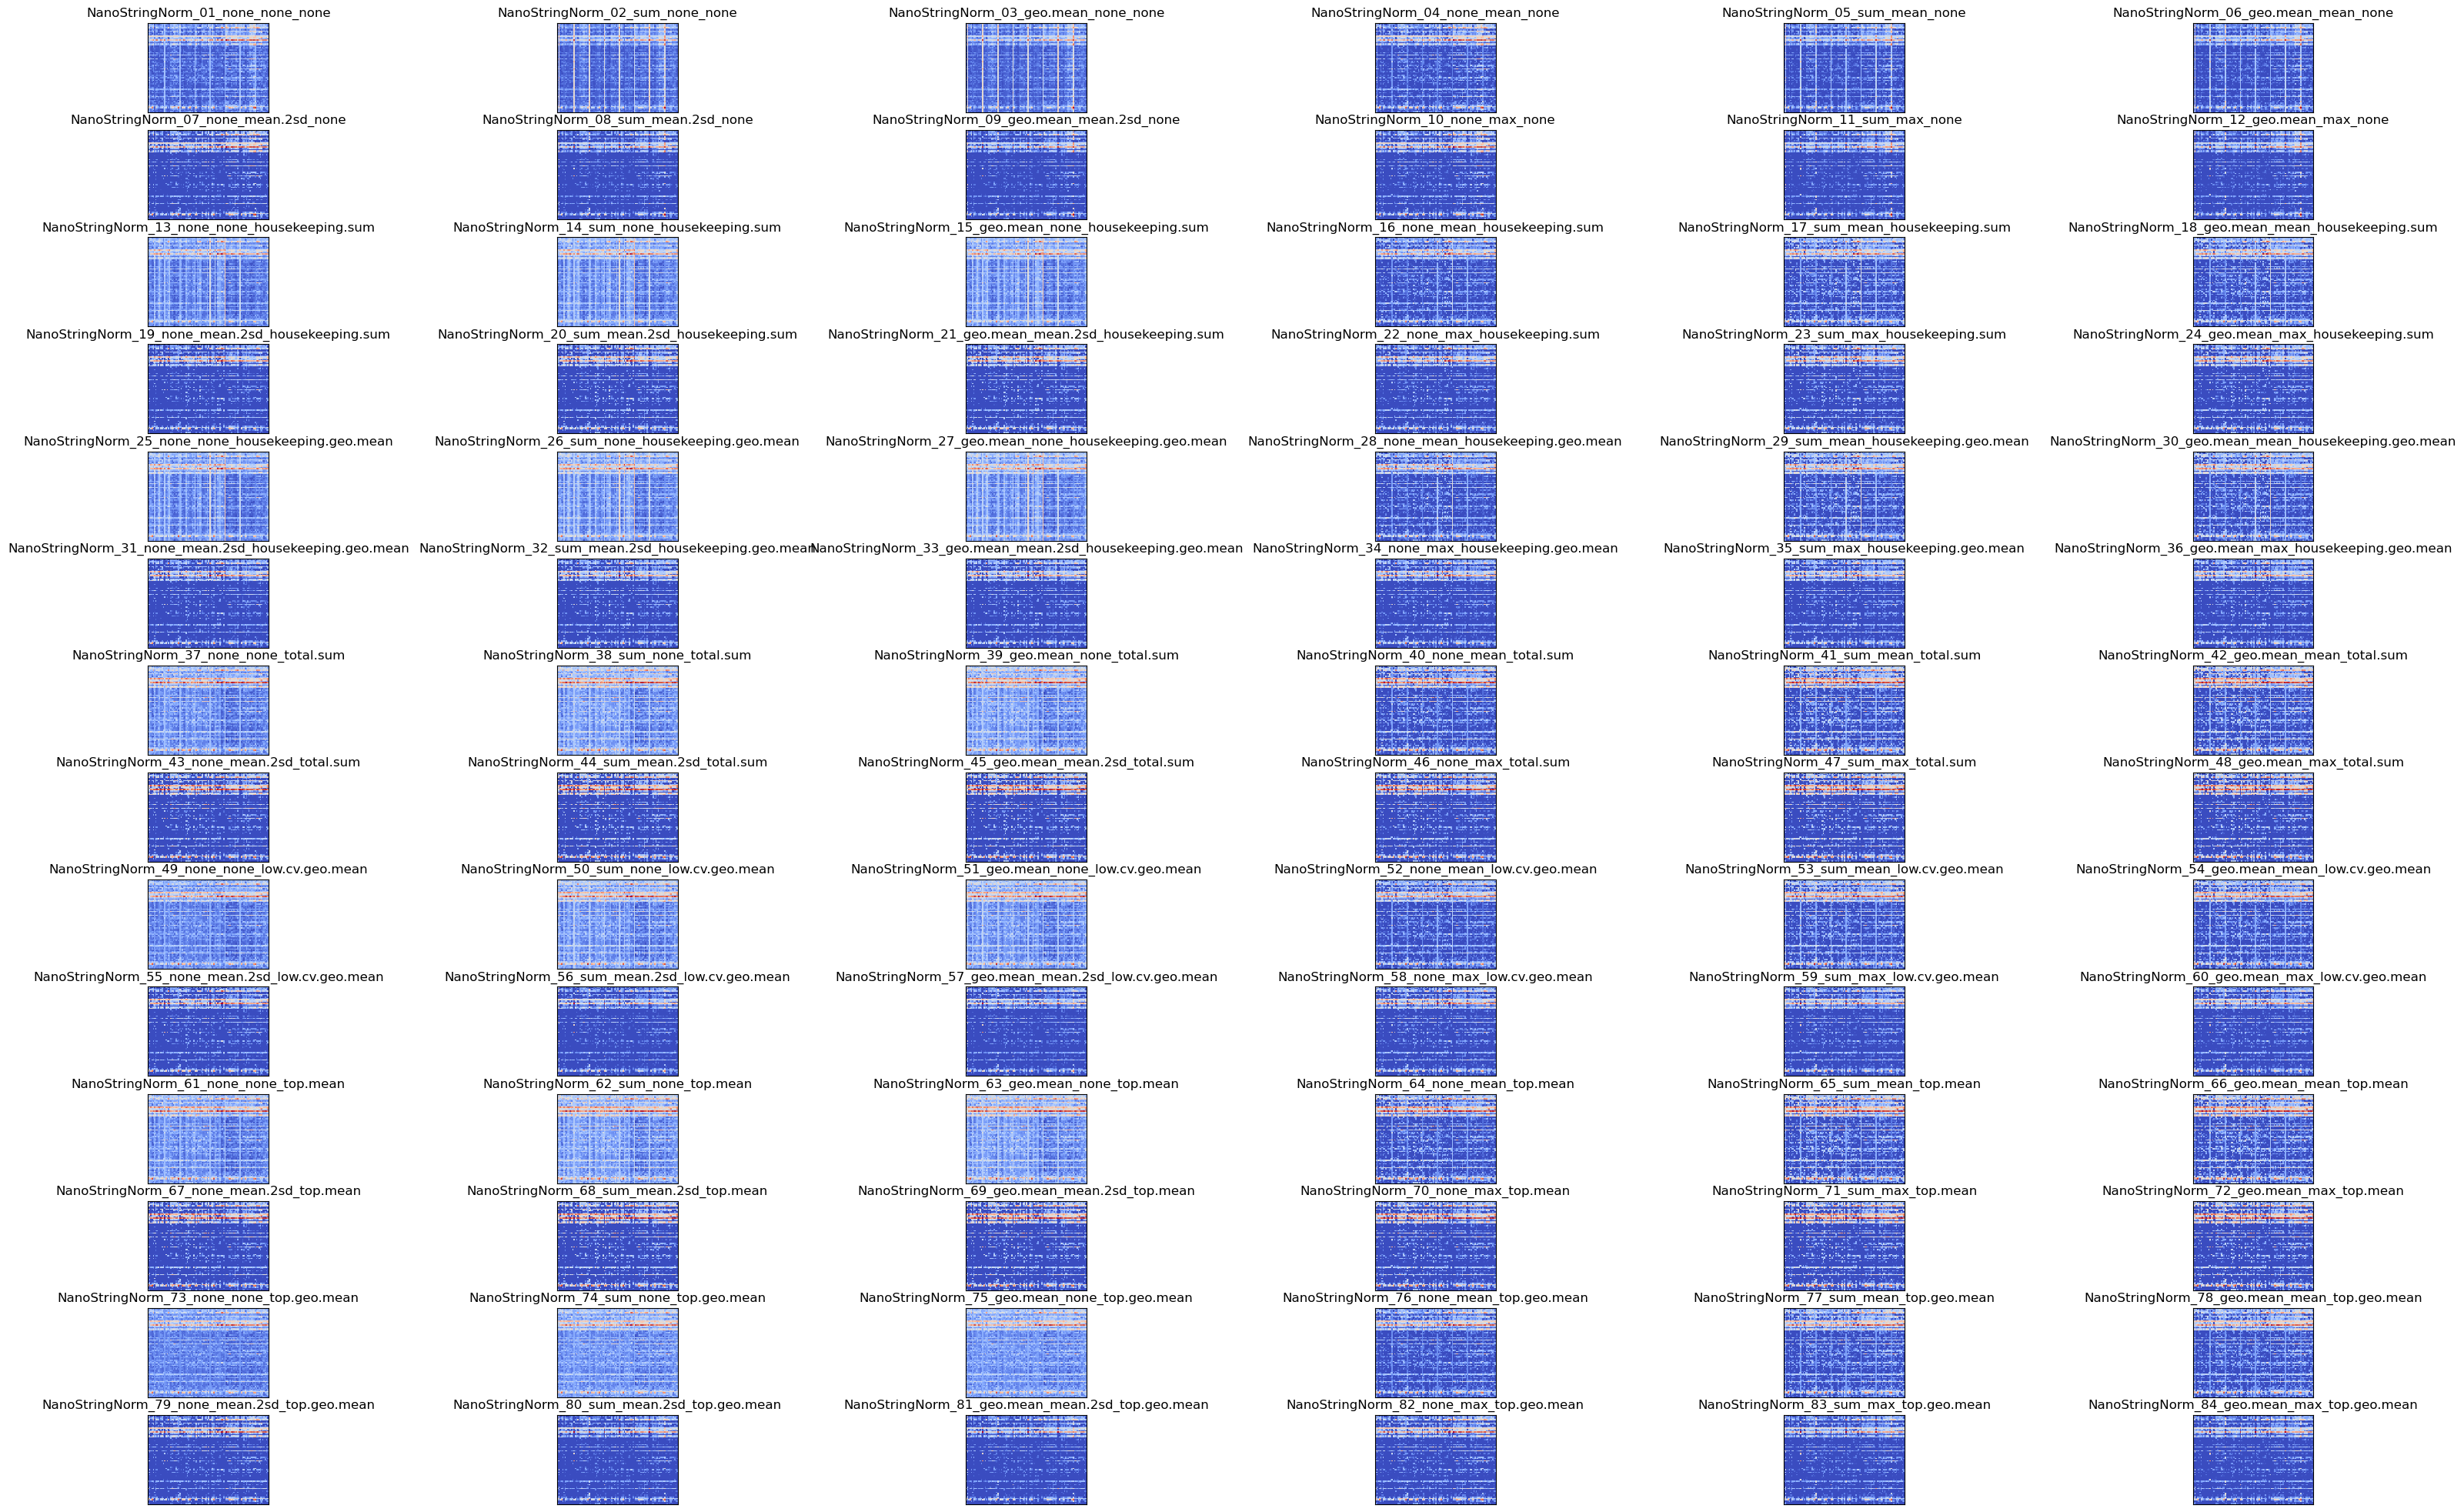

In [34]:
width = 6
height = 14

fig, axs = plt.subplots(height, width, figsize=[40,25])
# fig.suptitle('Nanostring Normalisation heatmaps')
for y in range(height):
    for x in range(width):
        fileIdx = x + y*width
        tempDF = pd.read_csv(os.path.join(normDir, 'NSNorm',files[fileIdx]), index_col=0)
#         axs[y][x].matshow(np.log2(tempDF + 1), aspect = 'auto', cmap='coolwarm')
        axs[y][x].matshow(np.log2(tempDF.loc[probeOrder,sampleOrder] + 1), cmap='coolwarm')
        axs[y][x].set_xticks([])
        axs[y][x].set_yticks([])
        axs[y][x].set_title(files[fileIdx][:-4])
    
# plt.tight_layout()
# fig.show()

# working

In [35]:
# Drop samples from sample info file

In [36]:
# generate groups for EdgeR analysis

In [37]:
# temp = noneMeanHKDF > 0 

In [38]:
# noneMeanHKDF = pd.read_csv(os.path.join(normDir, 'NSNorm',files[27]), index_col=0)
noneMeanHKDF = pd.read_csv(os.path.join(normDir, 'NSNormDropped',files[27]), index_col=0)


In [39]:
# noneMeanHKDF

In [40]:
# groupedExpressedIndex = noneMeanHKDF.loc[probeOrder].loc[((noneMeanHKDF > 0 ).sum(axis = 1) / len(noneMeanHKDF.columns) > 0.33333)].index


In [41]:
# groupedExpressedIndex

In [42]:
# len(groupedExpressedIndex)

In [43]:
QCData = pd.read_csv(os.path.join(normDir, QCDataFile), index_col=0)

QCData

,Code.Class,TMA_001_TNBC_240327a_001_Segment 1,TMA_001_TNBC_240327a_002_Segment 1,TMA_001_TNBC_240327a_003_Segment 1,TMA_001_TNBC_240327a_004_Segment 1,TMA_001_TNBC_240327a_005_Segment 1,TMA_001_TNBC_240327a_006_Segment 1,TMA_001_TNBC_240327a_007_Segment 1,TMA_001_TNBC_240327a_008_Segment 1,TMA_001_TNBC_240327a_009_Segment 1,...,TMA_002_TNBC_240327_029_Segment 1,TMA_002_TNBC_240327_030_Segment 1,TMA_002_TNBC_240327_031_Segment 1,TMA_002_TNBC_240327_032_Segment 1,TMA_002_TNBC_240327_033_Segment 1,TMA_002_TNBC_240327_034_Segment 1,TMA_002_TNBC_240327_035_Segment 1,TMA_002_TNBC_240327_036_Segment 1,TMA_002_TNBC_240327_037_Segment 1,TMA_002_TNBC_240327_038_Segment 1
Name,,,,,,,,,,,,,,,,,,,,,
HYB-POS,Positive,5775.984000,483.463650,5516.345700,4972.769000,5665.989300,3487.845000,4230.946300,4347.336000,4320.476600,...,4621.100600,4707.523000,4478.171400,4883.691400,3682.089000,3651.342800,3455.230500,3003.175300,4088.440200,3914.764600
HYB-NEG,Negative,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Rb IgG,Negative,1.640303,8.160318,0.858754,0.952625,0.696298,1.131133,0.932467,3.269025,2.192898,...,1.587668,3.117041,1.638341,1.502300,3.985114,2.009335,5.308453,1.221502,1.794516,2.811193
Ms IgG2a,Negative,3.485037,8.160318,5.108695,4.047950,2.842154,1.154267,0.932467,1.852125,0.931819,...,2.601080,0.851110,1.789399,1.640815,4.352549,3.291900,2.319161,1.334127,0.964969,1.023463
Ms IgG1,Negative,1.837347,8.160318,5.130201,4.268240,3.121692,2.028471,2.508300,1.627431,2.456323,...,1.419219,1.393164,3.661290,1.342909,1.781150,1.080484,2.847141,3.275709,0.964969,1.675287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PARP,Endogenous,84.463930,107.526855,8.698956,78.002920,76.928660,2.293033,32.135036,19.316725,6.478937,...,16.541405,20.103859,28.448923,47.701305,38.553947,15.950192,50.566480,10.908382,18.696493,18.596142
p53,Endogenous,54.937090,13.964646,28.149462,283.753850,4.766263,0.967847,61.435154,11.647476,4.687954,...,3.425342,5.043687,4.418335,17.826406,10.747193,11.921460,1.145282,6.588381,5.807416,4.043372
Neurofibromin,Endogenous,2.458121,8.160318,1.930363,4.996537,9.396905,1.131133,5.033650,2.449443,0.913144,...,4.459050,9.483910,3.834474,4.219291,11.192406,2.821663,0.993938,1.313682,4.199996,5.263590


# Run EdgeR analysis

Write comparisons to a text file that will be parsed by the r script

In form of factor.variable, factor.variable2, comparisonName
1 comparison per line

  make_option(c("-d", "--datadir"), type="character", default=NULL, 
              help="dataset file name", metavar="character"),
  make_option(c("-f", "--file"), type="character", default=NULL, 
              help="dataset file name", metavar="character"),
  make_option(c("-e", "--exportdir"), type="character", default="NSNorm", 
              help="dataset file name", metavar="character"),
  make_option(c("-i", "--sampleinfo"), type="character", default=NULL, 
              help="dataset file name", metavar="character")

### extract potential factors for analysis from info file

In [44]:
groups = [
    'Substrate',
    'Substrate.Diff',
    'Substrate.Diff.Layer'
]

### extract potential groups based on factors

### Show group numbers for each of the comparisons

In [45]:
comps = [
    [
        'Hydrogel - Spheroid'
    ],
    [
        'Hydrogel.BDNF - Hydrogel.SD',
        'Hydrogel.Dream - Hydrogel.SD',
        'Hydrogel.PDGF - Hydrogel.SD',
        'Spheroid.Hep - Spheroid.SD'    
    ],
    [
        'Hydrogel.SD.Outer - Hydrogel.SD.Inner',
        'Hydrogel.BDNF.Outer - Hydrogel.BDNF.Inner',
        'Hydrogel.Dream.Outer - Hydrogel.Dream.Inner',
        'Hydrogel.PDGF.Outer - Hydrogel.PDGF.Inner',
        'Spheroid.SD.Outer - Spheroid.SD.Inner',
        'Spheroid.Hep.Outer - Spheroid.Hep.Inner'
    ],
]

compNames = []
for g in comps:
    ctemp = []
    for c in g:
        c = c.replace('.','_')
        c = c.replace(' - ','_vs_')
        ctemp.append(c)
    compNames.append(ctemp)
    

compNames

[['Hydrogel_vs_Spheroid'],
 ['Hydrogel_BDNF_vs_Hydrogel_SD',
  'Hydrogel_Dream_vs_Hydrogel_SD',
  'Hydrogel_PDGF_vs_Hydrogel_SD',
  'Spheroid_Hep_vs_Spheroid_SD'],
 ['Hydrogel_SD_Outer_vs_Hydrogel_SD_Inner',
  'Hydrogel_BDNF_Outer_vs_Hydrogel_BDNF_Inner',
  'Hydrogel_Dream_Outer_vs_Hydrogel_Dream_Inner',
  'Hydrogel_PDGF_Outer_vs_Hydrogel_PDGF_Inner',
  'Spheroid_SD_Outer_vs_Spheroid_SD_Inner',
  'Spheroid_Hep_Outer_vs_Spheroid_Hep_Inner']]

In [46]:
# configDict['rootDir']

In [47]:
normPath = os.path.join('Normalisation','NSNormDropped')
print(normPath)

normFile = 'NanoStringNorm_49_none_none_low.cv.geo.mean.csv'
print(normFile)

exportdir = 'EdgeR'
runname = 'Default'
sampleinfoFile = 'sampleInfo_with_Wells.csv'

Normalisation/NSNormDropped
NanoStringNorm_49_none_none_low.cv.geo.mean.csv


### Set up config file for EdgeR

In [48]:
os.getcwd()

'/Users/upton6/Library/CloudStorage/OneDrive-QueenslandUniversityofTechnology/Documents/notebooks/Nanostring/Adams_Bray/DSP_EDA_Protein'

In [49]:
outFile = 'EdgeR_Config.txt'

outLines = []
for g in range(len(groups)):
    groupLine = 'GROUP:' + groups[g]
    outLines.append(groupLine)
    
    compLine = 'COMPARISON:'
    compNameLine = 'COMP_NAME:'
    for c in range(len(comps[g])):
        compLine += comps[g][c]
        compLine += ','
        compNameLine += compNames[g][c]
        compNameLine += ','
    
    outLines.append(compLine)
    outLines.append(compNameLine)

with open(outFile, 'w') as o:
    o.write('\n'.join(outLines))
    o.write('\n')

In [50]:

cmd = 'Rscript EdgeR.R -c ' + os.getcwd() + ' -d ' + configDict['rootDir'] + ' -n ' + normPath + ' -f ' + normFile + ' -e ' + exportdir + ' -r ' + runname  + ' -i ' + sampleinfoFile
print(cmd)
os.system(cmd)

Rscript EdgeR.R -c /Users/upton6/Library/CloudStorage/OneDrive-QueenslandUniversityofTechnology/Documents/notebooks/Nanostring/Adams_Bray/DSP_EDA_Protein -d /Users/upton6/Documents/Nanostring/projects/Adams/ -n Normalisation/NSNormDropped -f NanoStringNorm_49_none_none_low.cv.geo.mean.csv -e EdgeR -r Default -i sampleInfo_with_Wells.csv
[1] "Checking libraries:"


Loading required package: edgeR
Loading required package: limma
Loading required package: optparse
Loading required package: stringr


[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[1] "If any values above are FALSE, library availability must be checked"
[1] " "
[1] "groups"
[[1]]
[1] "Substrate"

[[2]]
[1] "Substrate" "Diff"     

[[3]]
[1] "Substrate" "Diff"      "Layer"    

[1] "/Users/upton6/Documents/Nanostring/projects/Larisa/2312_Run/DSP_Protein_Data/"
[1] "/Users/upton6/Documents/Nanostring/projects/Larisa/2312_Run/DSP_Protein_Data//Normalisation/NSNormDropped/NanoStringNorm_49_none_none_low.cv.geo.mean.csv"
[1] "Normalisation/NSNormDropped"
[[1]]
[1] "Substrate"

[[2]]
[1] "Substrate" "Diff"     

[[3]]
[1] "Substrate" "Diff"      "Layer"    

Coefficient:  1*Hydrogel -1*Spheroid 
                          logFC   logCPM          F      PValue       FDR
IBA1                  0.8144078 14.45042 12.0542175 0.000680205 0.0129239
Syndecan-1            0.3806968 14.11958  2.8167226 0.095428096 0.5440197
CD163                -0.5713246 18.05653  2.4933967 0.116797256 0.5440197
CD68                  0.2933901 14.

0

# Convert MD Plots to Volcano Plots

In [51]:
# Currently done in a separate notebook

In [52]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
# dataPath = '../../../Nanostring/projects/.../DSP_Protein_Data/'
dataPath = configDict['rootDir']
data = pd.read_csv(os.path.join(dataPath,'HK_Geo_Mean_Normalised.csv'), index_col = 0)
probeFilter = pd.read_csv(os.path.join(dataPath,'Probe_Filter.csv'), index_col = 0)
sampleInfo = pd.read_csv(os.path.join(dataPath,'Sample_Info.csv'), index_col = 0)

# dataPath = '../../../Nanostring/projects/.../EdgeR/EdgeR_normData.tsv'
dataPath = os.path.join(configDict['rootDir'], normPath, normFile)

data = pd.read_csv(dataPath, index_col = 0)

# dataPath = '../../../Nanostring/projects/.../DSP_Protein_Data/'
dataPath = configDict['rootDir']


In [ ]:
data

In [ ]:
sampleInfo.columns

In [ ]:
wb = load_workbook(os.path.join(dataPath,'Annotation template file-1a_wells_02.xlsx'))

print(wb.sheetnames)



In [ ]:
ws = wb['Annotation template']

segments = [[y.value for y in x] for x in ws[ws.calculate_dimension()]]
df = pd.DataFrame(segments)


rowLabels = df.iloc[1:,0]
colLabels = df.iloc[0,1:]
annotations = df.iloc[1:,1:]
rowLabels += '_'
rowLabels += df.iloc[1:,1]
rowLabels += '_Full ROI'



In [ ]:
rowLabels

In [ ]:
colLabels

In [ ]:
annotations.values

In [ ]:
sampleAnnotations = pd.DataFrame(annotations.values, index=rowLabels, columns=colLabels)

# sampleAnnotations = sampleAnnotations.T
# sampleAnnotations.set_index(0, drop=True, inplace=True)
# sampleAnnotations = sampleAnnotations.T
# sampleAnnotations.set_index('Scan name', drop=True, inplace=True)
# sampleAnnotations = sampleAnnotations.T



In [ ]:
sampleAnnotations

In [ ]:
sampleAnnotations = sampleAnnotations.join(sampleInfo.T,lsuffix='Drop').T

In [ ]:
sampleAnnotations.drop(labels=[x for x in sampleAnnotations.index if x.endswith('Drop')], inplace=True)

In [ ]:
sampleInfo = sampleAnnotations

In [ ]:
sampleInfo

In [ ]:
def standardize_data(arr):
         
    '''
    This function standardize an array, its substracts mean value, 
    and then divide the standard deviation.
    
    param 1: array 
    return: standardized array
    '''    
    rows, columns = arr.shape
    
    standardizedArray = np.zeros(shape=(rows, columns))
    tempArray = np.zeros(rows)
    
    for column in range(columns):
        
        mean = np.mean(X[:,column])
        std = np.std(X[:,column])
        tempArray = np.empty(0)
        
        for element in X[:,column]:
            
            tempArray = np.append(tempArray, ((element - mean) / std))
 
        standardizedArray[:,column] = tempArray
    
    return standardizedArray

In [ ]:
# Standardizing data

### I'm not sure that the transpose is what i want here. The data is the wrong shape and pc's seems to be being calculated for proteins instead of samples
X = endogNorm.transpose().values
# X = endogNorm.values
### Try to get pc's for samples
# X = endogNorm.values

## ??? With transpose makes PCA for effect of variables on smaples, without makes PCA for effects of variables on protein expression levels
###^^^ Maybe the other way round?



X_cols = endogNorm.columns
print(X_cols.shape)
y = endogNorm.index
print(y.shape)
X = standardize_data(X)
print(X.shape)


In [ ]:
# Calculating the covariance matrix

covariance_matrix = np.cov(X.T)
# covariance_matrix = np.cov(X)



print(covariance_matrix.shape)


In [ ]:
# Using np.linalg.eig function

eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
print("Eigenvector: \n",eigen_vectors,"\n")
print("Eigenvalues: \n", eigen_values, "\n")
print(eigen_vectors.shape)

In [ ]:
eigenDF = pd.DataFrame(eigen_vectors, index=[endogNorm.index], columns=[endogNorm.index])
# eigenDF = pd.DataFrame(eigen_vectors, index=[endogNorm.columns], columns=[endogNorm.columns])

In [ ]:
# Calculating the explained variance on each of components


variance_explained = []
for i in eigen_values:
     variance_explained.append((i/sum(eigen_values))*100)
        
print(variance_explained)

In [ ]:
# Identifying components that explain at least 95%

cumulative_variance_explained = np.cumsum(variance_explained)
print(cumulative_variance_explained)


In [ ]:
cumulative_variance_explained = [np.float64(x) for x in cumulative_variance_explained]

In [ ]:
cumulative_variance_explained[0].dtype

In [ ]:
# Visualizing the eigenvalues and finding the "elbow" in the graphic


sns.lineplot(x = [i for i in range(len(cumulative_variance_explained))], y=cumulative_variance_explained)
# plt.xlabel("Number of components")
# plt.ylabel("Cumulative explained variance")
# plt.title("Explained variance vs Number of components")



# ToDo:
# Add lines for 95% variance, and number of components describing at least 95% of variance



In [ ]:
# Using two first components (because those explain more than 95%)

projection_matrix = (eigen_vectors.T[:][:50]).T
print(projection_matrix)

In [ ]:
colours = ['g' if x.split('_')[-1] == 'Tumour' else 'r' for x in X_cols]
colours = ['g' if x.split('_')[-1] == 'Tumour' else 'r' if x.split('_')[-1] == 'Immune' else 'purple' for x in X_cols]


In [ ]:
# I dont think this gives relevant info. projection matrix needs to be combined with original data to see effects of components on patients

plt.scatter([x[0] for x in projection_matrix], [x[1] for x in projection_matrix])#, c=colours)

projection_matrix.shape

In [ ]:
plt.scatter([x[2] for x in projection_matrix], [x[1] for x in projection_matrix])#, c=colours)


In [ ]:
plt.scatter([x[2] for x in projection_matrix], [x[3] for x in projection_matrix])#, c=colours)


In [ ]:
# Getting the product of original standardized X and the eigenvectors 


X_pca = X.dot(projection_matrix)
print(X_pca)

In [ ]:
X_pca.shape

In [ ]:
sampleInfo

In [ ]:
# tagDF = pd.DataFrame( data=[x.split(',') for x in sampleInfo.loc['Segment tags']], index=sampleInfo.columns, columns=['Obese','Arth','Patellar'])

In [ ]:
# tagDF

In [ ]:
# sampleInfo = pd.concat([sampleInfo,tagDF.T])

In [ ]:
sampleInfo

In [ ]:
inforSortedIndex = sampleInfo.sort_values(by=['Obese','arthritis','TMA_Core'], axis=1).columns

In [ ]:
### Add umap / tSNE analysis here